In [83]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np

close = pd.read_csv("close_data.csv")

close.index = pd.to_datetime(close['Date'], format='%Y-%m-%d')
close = close.drop('Date', axis=1)
close

,AAPL,AMZN,BRK-B,GOOGL,JNJ,META,MSFT,NVDA,TSLA,V
Date,,,,,,,,,,
2024-02-21,181.463181,168.589996,409.250000,142.035110,153.747635,466.743652,399.132782,67.452881,194.770004,274.710510
2024-02-22,183.503525,174.580002,415.160004,143.569534,155.462631,484.793915,408.531006,78.515747,197.410004,281.648743
2024-02-23,181.662216,174.990005,417.220001,143.440033,156.809418,482.699707,407.230957,78.794655,191.970001,281.499847
2024-02-26,180.308624,174.729996,409.140015,137.073105,155.792053,480.415955,404.452179,79.069588,199.399994,282.045776
2024-02-27,181.771698,173.539993,408.910004,138.378372,155.976166,485.711365,404.392609,78.678688,199.729996,281.073029
...,...,...,...,...,...,...,...,...,...,...
2025-02-14,244.600006,228.679993,479.589996,185.229996,154.910004,736.669983,407.612671,138.850006,355.839996,353.809998
2025-02-18,244.470001,226.649994,482.820007,183.770004,154.990005,716.369995,408.820282,139.399994,354.109985,356.730011
2025-02-19,244.869995,226.630005,483.769989,185.270004,157.889999,703.770020,413.940002,139.229996,360.559998,355.230011


<Axes: xlabel='Date'>

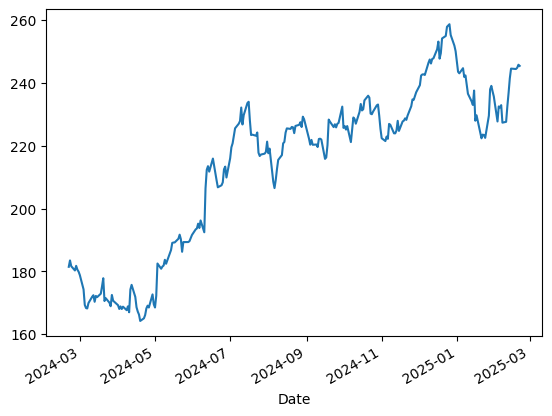

In [84]:
stock_to_use = 'AAPL'

stock = close[stock_to_use]
stock.plot()

In [85]:
def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

WINDOW_SIZE = 10
X1, y1 = df_to_X_y(stock, WINDOW_SIZE)
X1.shape, y1.shape

((242, 10, 1), (242,))

In [86]:
X_train1, y_train1 = X1[:150], y1[:150]
X_val1, y_val1 = X1[150:200], y1[150:200]
X_test1, y_test1 = X1[200:], y1[200:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((150, 10, 1), (150,), (50, 10, 1), (50,), (42, 10, 1), (42,))

In [87]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [88]:
cp1 = ModelCheckpoint('model1/best_model.keras', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.1), metrics=[RootMeanSquaredError()])

In [89]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=1, callbacks=[cp1])

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 39302.5391 - root_mean_squared_error: 198.2236 - val_loss: 39738.7383 - val_root_mean_squared_error: 199.3458


In [90]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = 'model1/best_model.keras'
cp1 = ModelCheckpoint(checkpoint_path, save_best_only=True)

In [91]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


,Train Predictions,Actuals
0,34.370247,168.325180
1,34.370251,168.205765
2,34.370251,169.927612
3,34.370243,171.938141
4,34.370239,172.415863
...,...,...
145,34.370197,226.281982
146,34.370197,225.174408
147,34.370197,226.301941
148,34.370197,221.203156


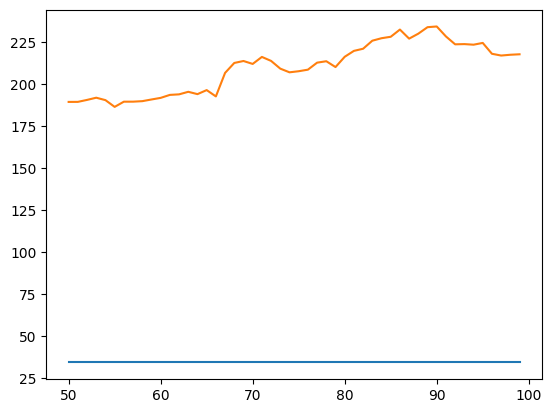

In [92]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])